In [24]:
# !pip install -U kaleido
# !pip install --upgrade plotly

### Import Libraries

In [25]:
import pandas as pd
from matplotlib import pyplot as plt 
from geopy.geocoders import Nominatim
from time import sleep

### Import data

In [26]:
df = pd.read_csv('D:/Daniels/exercises/ubuntu/phd_work/data/pprl_papers_data_extraction.csv')
df.head()

,search_#,study_title,link,geographic_region,state_country,city,evaluation,date_done,year,topic,...,More explanation on AIMS,Sections,Authors,Skimming_through_scanning,fulltext,mendeley_zotero,citations,Authors_x,Databases,author_affiliation
0,717165525459,Population-level surveillance of congenital he...,https://doi.org/10.1016/j.ahj.2020.04.008,USA;,Colorado;,NaN,great-practical,7/17/2025,2020.0,congenital heart defects (CHD); health care ut...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,717165525405,Real-world effectiveness of admissions to a te...,https://doi.org/10.1192/bjo.2020.51,Europe;,United Kingdom;,Scotland; Wales; Northern Ireland; England;,general-info,7/16/2025,2020.0,cohort identification; National Psychosis Unit...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,717165525164,Population Data BC: Supporting population data...,https://doi.org/10.23889/ijpds.v4i2.1133,Canada;,British Columbia;,Vancouver;,Great,7/16/2025,2020.0,References for building of national data repos...,...,NaN,NaN,Ark TK,yes,Yes-partially,NaN,Int J Popul Data Sci. 2020 Mar 26;4(2):1133. d...,Ark TK,Int J Popul Data Sci,NaN
3,717165525888,Population Data Centre Profiles: Centre for Da...,https://doi.org/10.23889/ijpds.v4i2.1139,Australia;,Western Australia;,"Curtin University, Western Australia;",NaN,7/16/2025,2020.0,Centre for Data Linkage (CDL); Curtin Universi...,...,NaN,NaN,Boyd JH,NaN,NaN,NaN,Int J Popul Data Sci. 2020 Mar 11;4(2):1139. d...,Boyd JH,Int J Popul Data Sci,NaN
4,717165525189,Secure Record Linkage of Large Health Data Set...,https://doi.org/10.2196/18920,Australia;,Western Australia;,"Bentley, Western Australia;",great-practical,7/15/2025,2020.0,containers; linkage workloads; multiple nodes;...,...,NaN,NaN,Brown AP,NaN,NaN,NaN,JMIR Med Inform. 2020 Sep 23;8(9):e18920. doi:...,Brown AP,JMIR Med Inform,NaN


In [27]:
df.shape

(534, 88)

### Split locations

In [28]:
# Remove trailing semicolons and split into lists
df['countries_list'] = df['state_country'].str.rstrip(';').str.split(';')

# Explode into multiple rows
df_exploded = df.explode('countries_list')

# Clean up spaces and underscores
df_exploded['countries_clean'] = df_exploded['countries_list'].str.replace('_', ' ').str.strip()

# Drop NaNs or empty values
df_exploded = df_exploded[df_exploded['countries_clean'].notna() & (df_exploded['countries_clean'] != '')]


In [29]:
df_exploded.countries_clean.nunique()

64

### Geolocator - more time taken here

In [30]:
geolocator = Nominatim(user_agent="geoapi")

# Define function with delay to avoid rate-limiting
def geocode_place(place):
    try:
        loc = geolocator.geocode(place)
        if loc:
            return pd.Series([loc.latitude, loc.longitude])
    except:
        return pd.Series([None, None])
    return pd.Series([None, None])

# Apply with delay
df_exploded[['lat', 'lon']] = df_exploded['countries_clean'].apply(lambda x: geocode_place(x))

WARNING	urllib3.connectionpool:connectionpool.py:urlopen()- Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=Louisiana&format=json&limit=1
WARNING	urllib3.connectionpool:connectionpool.py:urlopen()- Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=Norway&format=json&limit=1
WARNING	urllib3.connectionpool:connectionpool.py:urlopen()- Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=United+Kingdom&format=json&limit=1
WARNING	url

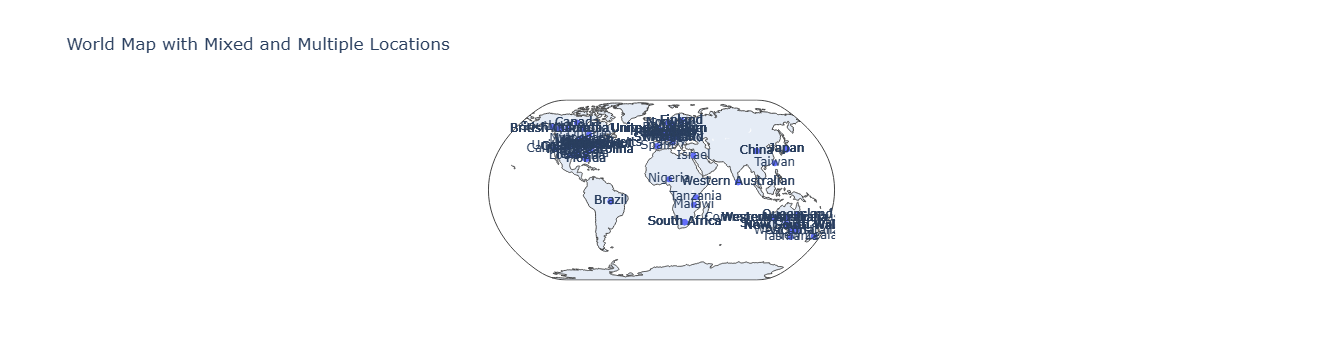

In [31]:
import plotly.express as px

fig = px.scatter_geo(df_exploded,
                     lat='lat',
                     lon='lon',
                     text='countries_clean',
                     projection="natural earth",
                     title="World Map with Mixed and Multiple Locations")

fig.write_html("maps/map_output.html")

fig.show()


### Map without country names (Size not factored)

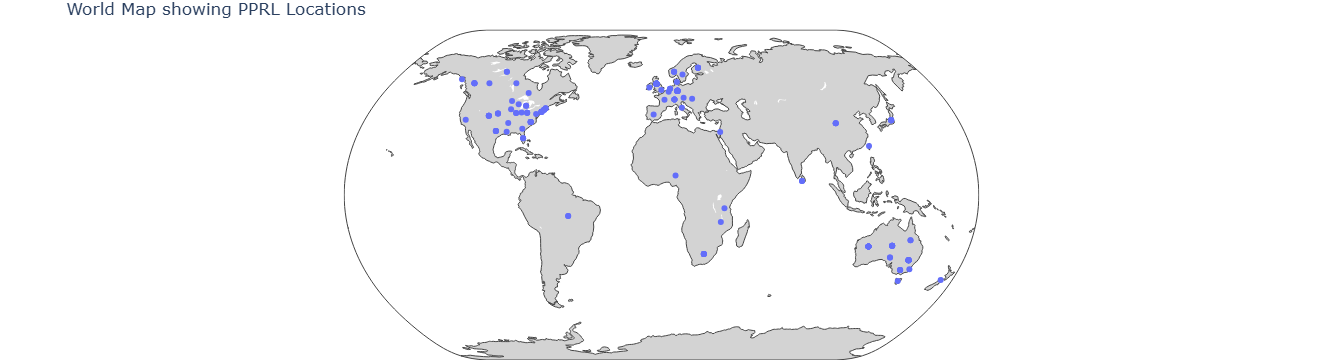

In [32]:
import plotly.express as px

fig = px.scatter_geo(df_exploded,
                     lat='lat',
                     lon='lon',
                     # text='countries_clean',
                     hover_name='countries_clean',
                     projection="natural earth",
                     title="World Map showing PPRL Locations")

# Hide country names (labels), keep borders and land
fig.update_geos(
    showcountries=False,    # hides country names
    showcoastlines=True,
    showland=True,
    landcolor="lightgray"
)

# Optional: adjust layout margins if needed
fig.update_layout(
    margin={"r":0, "t":30, "l":0, "b":0}
)

# Save map
fig.write_html("maps/map_output_ii.html")

# Show map
fig.show()


### Map 3 - with size as a factor

In [33]:
# Count occurrences of each location
size_df = df_exploded['countries_clean'].value_counts().reset_index()
size_df.columns = ['countries_clean', 'size']

# Merge back to main DataFrame
df_exploded = df_exploded.merge(size_df, on='countries_clean')
df_exploded.head()

,search_#,study_title,link,geographic_region,state_country,city,evaluation,date_done,year,topic,...,mendeley_zotero,citations,Authors_x,Databases,author_affiliation,countries_list,countries_clean,lat,lon,size
0,717165525459,Population-level surveillance of congenital he...,https://doi.org/10.1016/j.ahj.2020.04.008,USA;,Colorado;,NaN,great-practical,7/17/2025,2020.0,congenital heart defects (CHD); health care ut...,...,NaN,NaN,NaN,NaN,NaN,Colorado,Colorado,38.725178,-105.607716,4
1,717165525347,The role of all-payer claims databases to expa...,https://doi.org/10.1111/1475-6773.13901,USA;,Colorado;,NaN,practical-good;,6/14/2025,2022.0,linkage rate; uninsured patients; private plan...,...,NaN,NaN,NaN,NaN,NaN,Colorado,Colorado,38.725178,-105.607716,4
2,717165525636,Medical Needs after Pediatric Traumatic Brain ...,https://doi.org/10.23889/ijpds.v3i4.968,USA;,Colorado;,Colorado;,NaN,11/13/2023,2018.0,"Identifying patterns using unsupervised ML, TB...",...,NaN,NaN,NaN,NaN,NaN,Colorado,Colorado,38.725178,-105.607716,4
3,717165525602,Scalable Secure Privacy-Preserving Record Link...,https://doi.org/10.23889/ijpds.v3i4.638,USA;,Colorado;,Colorado;,Great,11/13/2023,2018.0,"PPRL on the cloud, parallel processing (record...",...,NaN,NaN,NaN,NaN,NaN,Colorado,Colorado,38.725178,-105.607716,4
4,717165525405,Real-world effectiveness of admissions to a te...,https://doi.org/10.1192/bjo.2020.51,Europe;,United Kingdom;,Scotland; Wales; Northern Ireland; England;,general-info,7/16/2025,2020.0,cohort identification; National Psychosis Unit...,...,NaN,NaN,NaN,NaN,NaN,United Kingdom,United Kingdom,54.702354,-3.276575,28


In [34]:
import plotly.express as px

fig = px.scatter_geo(
    df_exploded,
    lat='lat',
    lon='lon',
    hover_name='countries_clean',  # Appears on hover only
    color='countries_clean',                # Colors by region
    size='size',                  # Bubble size
    projection="natural earth",
    title="World Map with Colored and Scaled Bubbles by Region"
)

# Hide country labels and customize map appearance
fig.update_geos(
    showcountries=False,
    showland=True,
    landcolor="lightgray",
    showcoastlines=True,
    coastlinecolor="gray"
)

# Customize layout and legend appearance
fig.update_layout(
    legend_title_text='Region',
    margin={"r":0,"t":30,"l":0,"b":0}
)

# Save and show
# fig.write_image("maps/pprl_map_colored_iii.png", scale=2)
fig.write_html("maps/pprl_map_colored_iii.html")
fig.show()

In [35]:
# import kaleido
# print("Kaleido is working!")

### Top 12 countries

In [36]:
# Get top 12 countries sorted by size
top_12_countries = size_df.sort_values(by='size', ascending=False).head(12)

# Styled Pandas Table with formatting
styled_table = top_12_countries.style \
    .set_caption("Top 12 Countries with Most Record Linkage Work") \
    .hide(axis="index") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('color', '#2a3f5f'),
                                          ('font-size', '18px'),
                                          ('font-weight', 'bold'),
                                          ('text-align', 'center')]},
        {'selector': 'th', 'props': [('background-color', '#f2f2f2'),
                                     ('font-size', '14px'),
                                     ('text-align', 'center')]},
        {'selector': 'td:nth-child(1)', 'props': [('text-align', 'left'), ('min-width', '200px')]},
        {'selector': 'td:nth-child(2)', 'props': [('text-align', 'center'), ('min-width', '100px')]}
    ]) \
    .format({'size': '{:,}'})

styled_table

countries_clean,size
United Kingdom,28
Germany,14
New South Wales,10
Western Australia,8
New York,6
South Africa,5
Japan,5
North Carolina,5
Colorado,4
British Columbia,4


### Export styled table

In [37]:
with open("maps/top_12_countries.html", "w") as f:
    f.write(styled_table.to_html())

### End of the maps